# Setup

## Mount Drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd drive/'My Drive'/repositories/moleculenet/notebooks

/content/drive/My Drive/repositories/moleculenet/lipophilicity


In [5]:
%ls

ecfp4_features  ecfp6_pd.pkl            Lipo_README
ecfp4_pd.pkl    get_fingerprints.ipynb  rf_grid_search_on_fingerprints.ipynb
ecfp6_features  Lipophilicity.csv


## Import modules

In [180]:
# standard modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# evaluating metrics
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

# model selection
from sklearn.model_selection import train_test_split, PredefinedSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

# preprocessing
from sklearn.feature_selection import VarianceThreshold # to remove zero-var features
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.kernel_ridge import KernelRidge

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern


# pipelines
# https://scikit-learn.org/stable/modules/compose.html#combining-estimators
from sklearn.pipeline import make_pipeline, Pipeline

In [137]:
import sklearn
print(sklearn.__version__)

0.23.1


In [138]:
try:
    import forestci as fci
except ImportError as e:
    ! pip install forestci
    ! pip install forestci
    import forestci as fci

In [139]:
print(fci.__version__)

0.3


## Set plotting style

In [6]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

# Load Data

In [31]:
dataset = 'lipophilicity'
smile_type = 'original'

In [32]:
# READ_ONLY
assert dataset in ['esol', 'freesolv', 'lipophilicity']
assert smile_type in ['original', 'protonated']

## Load Features

In [154]:
# original data
id_smile_target = pd.read_csv(f'../data/{dataset}_{smile_type}_IdSmileTarget.csv', index_col=0)

# features
rdkit_features = pd.read_csv(f'../data/{dataset}_{smile_type}_rdkit_features.csv', index_col=0)
ecfp4_features = pd.read_csv(f'../data/{dataset}_{smile_type}_ecfp4_features.csv', index_col=0)
ecfp6_features = pd.read_csv(f'../data/{dataset}_{smile_type}_ecfp6_features.csv', index_col=0)

# load target
target = id_smile_target['target']

In [65]:
print('rdkit_features.shape: ', rdkit_features.shape)
print('ecfp4_features.shape: ',   ecfp4_features.shape)
print('ecfp6_features.shape: ',   ecfp6_features.shape)
print('target.shape:         ',       target.shape)

rdkit_features.shape:  (4200, 200)
ecfp4_features.shape:  (4200, 2048)
ecfp6_features.shape:  (4200, 2048)
target.shape:          (4200,)


In [66]:
rdkit_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CHEMBL596271,8.838871,-4.082382,8.838871,0.008322,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1951080,15.117958,-6.843264,15.117958,0.920611,0.545587,494.591,468.383,494.118143,178.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CHEMBL1771,13.321227,-3.906276,13.321227,0.250582,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CHEMBL234951,14.213604,-4.272077,14.213604,0.187400,0.506650,419.890,401.746,419.070655,146.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CHEMBL565079,14.167882,-4.810274,14.167882,0.671279,0.747686,381.480,354.264,381.216475,148.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
ecfp4_features.head()

,ecfp4-0,ecfp4-1,ecfp4-2,ecfp4-3,ecfp4-4,ecfp4-5,ecfp4-6,ecfp4-7,ecfp4-8,ecfp4-9,...,ecfp4-2038,ecfp4-2039,ecfp4-2040,ecfp4-2041,ecfp4-2042,ecfp4-2043,ecfp4-2044,ecfp4-2045,ecfp4-2046,ecfp4-2047
CHEMBL596271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1951080,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1771,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL234951,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL565079,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
ecfp6_features.head()

,ecfp6-0,ecfp6-1,ecfp6-2,ecfp6-3,ecfp6-4,ecfp6-5,ecfp6-6,ecfp6-7,ecfp6-8,ecfp6-9,...,ecfp6-2038,ecfp6-2039,ecfp6-2040,ecfp6-2041,ecfp6-2042,ecfp6-2043,ecfp6-2044,ecfp6-2045,ecfp6-2046,ecfp6-2047
CHEMBL596271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1951080,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
CHEMBL1771,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL234951,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL565079,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
target.head()

id
CHEMBL596271     3.54
CHEMBL1951080   -1.18
CHEMBL1771       3.69
CHEMBL234951     3.37
CHEMBL565079     3.10
Name: target, dtype: float64

# Establish Feature Sets

In [70]:
all_features = pd.concat([rdkit_features, ecfp4_features, ecfp6_features], axis='columns')

In [71]:
all_features.shape

(4200, 4296)

In [72]:
all_features.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,ecfp6-2038,ecfp6-2039,ecfp6-2040,ecfp6-2041,ecfp6-2042,ecfp6-2043,ecfp6-2044,ecfp6-2045,ecfp6-2046,ecfp6-2047
CHEMBL596271,8.838871,-4.082382,8.838871,0.008322,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1951080,15.117958,-6.843264,15.117958,0.920611,0.545587,494.591,468.383,494.118143,178.0,0.0,...,0,0,0,0,0,0,0,1,0,0
CHEMBL1771,13.321227,-3.906276,13.321227,0.250582,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL234951,14.213604,-4.272077,14.213604,0.187400,0.506650,419.890,401.746,419.070655,146.0,0.0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL565079,14.167882,-4.810274,14.167882,0.671279,0.747686,381.480,354.264,381.216475,148.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Creating feature_sets dictionary with pd.Index objects (containing feature names) as its elements

### Add original features into feature_sets

In [74]:
feature_sets = {
    'RDKit': rdkit_features.columns,
    'ECFP-4': ecfp4_features.columns,
    'ECFP-6': ecfp6_features.columns,
}

### Adding a combination of RDKit features with every feature set in the feature_sets dictionary

In [82]:
for f in ['ECFP-4', 'ECFP-6']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])

In [86]:
list(feature_sets.keys())

['RDKit', 'ECFP-4', 'ECFP-6', 'ECFP-4 + RDKit', 'ECFP-6 + RDKit']

# Train-test split

In [181]:
# use only 100 observations with 90-10 train-test-split for computational efficiency
use_small = True

## Choose main feature set to use for now

In [182]:
feature_set = 'RDKit'

In [183]:
if use_small:
    np.random.seed(42)
    small = np.random.choice(len(target), 100, replace=False)
    
    test = small[:int(len(small)*0.1)]
    
    # removing from all_features pd.DataFrame the protein-ligand complexes present in the test set
    train = np.array(list(set(small).difference(set(test))))
    
    # Creating training and test, features and targets pd.DataFrames
    X_train = all_features[feature_sets[feature_set]].iloc[train]
    y_train = targets = target.iloc[train]
    
    X_test = all_features[feature_sets[feature_set]].iloc[test]
    y_test = target.iloc[test]
else:
    X_train, X_test, y_train, y_test = train_test_split(all_features, target, test_size=0.1, random_state=42)

In [184]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90, 200) (90,)
(10, 200) (10,)


### Create `binned` - an integer representation of all target values in the training set

In [185]:
binned = y_train.apply(lambda x: int(x))
binned.unique()
print(binned.value_counts())

 2    30
 3    19
 1    18
 0    17
 4     4
-1     2
Name: target, dtype: int64


# Grid Search for parameters

## Separately trying to optimize parameters for NN

In [186]:
"""
# Randomized Grid Search takes a lot of time, use best parameters straight away
# while reproducing the results the first time

nn_params = {
    'nn__hidden_layer_sizes': [(n,) for n in np.arange(5, 100, 5)],
    'nn__activation': ['tanh'],
    'nn__alpha': 10.0 ** -np.arange(1, 7),
    'nn__max_iter': [500, 1000],
}
"""

nn_params = {
    'nn__max_iter': [1000],
    'nn__hidden_layer_sizes': [(50,)],
    'nn__alpha': [0.1],
    'nn__activation': ['tanh']
}

cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, binned)
pipe = Pipeline([('zero-var-feature-remover', VarianceThreshold()), ('scaler', StandardScaler()), ('nn', MLPRegressor())])
nn_estimator = RandomizedSearchCV(pipe, param_distributions=nn_params, cv=cv,
                                  refit=True, n_iter=100, n_jobs=-1, verbose=10,
                                  random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/macbookair/opt/miniconda3/envs/batch-msc/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/Users/macbookair/opt/miniconda3/envs/batch-msc/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.9s finished


In [189]:
nn_best_params = nn_estimator.best_params_

%store nn_best_params

Stored 'nn_best_params' (dict)


In [190]:
# retrieve 
%store -r nn_best_params
print(nn_best_params)

{'nn__max_iter': 1000, 'nn__hidden_layer_sizes': (50,), 'nn__alpha': 0.1, 'nn__activation': 'tanh'}


# Run a vanilla RF on ECFP-4

In [18]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1,
                           verbose = 1)

rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [19]:
y_hat = rf.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


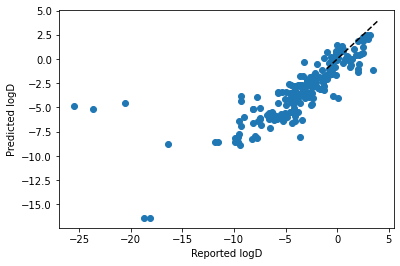

In [20]:
# Plot predicted pK without error bars
plt.scatter(y_test, y_hat)
plt.plot([-1, 4], [-1, 4], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')
plt.show()

In [21]:
# Calculate the variance
V_IJ_unbiased = fci.random_forest_error(rf, X_train, X_test)

TypeError: _generate_sample_indices() missing 1 required positional argument: 'n_samples_bootstrap'

In [22]:
print(len(V_IJ_unbiased))
V_IJ_unbiased[:20]

NameError: name 'V_IJ_unbiased' is not defined

In [23]:
# Plot error bars for predicted pK using unbiased variance
plt.errorbar(x=y_test, y=y_hat, yerr=np.sqrt(V_IJ_unbiased), fmt='o')
plt.plot([-1, 4], [-1, 4], 'k--')
plt.xlabel('Reported logD')
plt.ylabel('Predicted logD')
plt.show()

NameError: name 'V_IJ_unbiased' is not defined